In [1]:
%load_ext autoreload
%autoreload 2
from ayniy.utils import init_notebook
init_notebook()

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb

In [3]:
def extract_feat(sid):
    df = pd.read_csv(f'../dataset/train/{sid}.csv')

    df['diff_usr_ball'] = ((df['usr_x'] - df['bal_x'])**2 + (df['usr_y'] - df['bal_y'])**2)
    df['diff_usr_uDF'] = ((df['usr_x'] - df['uDF_x'])**2 + (df['usr_y'] - df['uDF_y'])**2)
    df['diff_usr_scr'] = ((df['usr_x'] - df['scr_x'])**2 + (df['usr_y'] - df['scr_y'])**2)
    df['diff_scr_uDF'] = ((df['scr_x'] - df['uDF_x'])**2 + (df['scr_y'] - df['uDF_y'])**2)
    df['diff_scr_ball'] = ((df['scr_x'] - df['bal_x'])**2 + (df['scr_y'] - df['bal_y'])**2)
    df['diff_uDF_ball'] = ((df['uDF_x'] - df['bal_x'])**2 + (df['uDF_y'] - df['bal_y'])**2)

    return (df['diff_usr_ball'].min(), df['diff_usr_uDF'].min(), df['diff_usr_scr'].min(), df['diff_scr_uDF'].min(), df['diff_scr_ball'].min(), df['diff_uDF_ball'].min(), len(df))

In [4]:
X_train = []

for i in range(1528):
    X_train.append(extract_feat(str(i).zfill(4)))

In [5]:
X_test = []

for i in range(382):
    X_test.append(extract_feat(str(i).zfill(4)))

In [6]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
cols = ['min_diff_usr_ball', 'min_diff_usr_uDF', 'min_diff_usr_scr', 'min_diff_scr_uDF', 'min_diff_scr_ball', 'min_diff_uDF_ball', 'num_df']
X_train.columns = cols
X_test.columns = cols

In [7]:
X_train.head()

,min_diff_usr_ball,min_diff_usr_uDF,min_diff_usr_scr,min_diff_scr_uDF,min_diff_scr_ball,min_diff_uDF_ball,num_df
0,0.0073,4.0034,3.4885,0.0000,1.9105,3.3266,136
1,3.3169,0.2953,1.8464,0.4196,0.0586,1.4689,116
2,6.8328,0.2393,6.6420,0.1165,42.7444,0.9640,92
3,0.0004,0.1450,0.1949,0.6161,0.5153,0.1972,98
4,4.5473,0.8989,0.8105,0.0073,14.9850,6.7097,106


In [8]:
y_train = pd.Series([1 if i < 400 else 0 for i in range(1528)])

In [9]:
from sklearn.model_selection import StratifiedKFold


y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

params = {
    'num_leaves': 16,
    'max_depth': 3,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.7,
    'min_data_in_leaf': 10,
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
    "verbosity": -1,
    "random_state": 42
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    model = lgb.train(params, lgb_train,
                                   valid_sets=[lgb_train, lgb_eval],
                                   verbose_eval=10,
                                   num_boost_round=1000,
                                   early_stopping_rounds=10)

    oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

Training until validation scores don't improve for 10 rounds.
[10]	training's auc: 0.864897	valid_1's auc: 0.77182
[20]	training's auc: 0.884801	valid_1's auc: 0.797815
[30]	training's auc: 0.901117	valid_1's auc: 0.80448
[40]	training's auc: 0.909235	valid_1's auc: 0.810896
[50]	training's auc: 0.917728	valid_1's auc: 0.820465
[60]	training's auc: 0.925	valid_1's auc: 0.821294
[70]	training's auc: 0.93036	valid_1's auc: 0.823396
Early stopping, best iteration is:
[69]	training's auc: 0.930062	valid_1's auc: 0.823838
Training until validation scores don't improve for 10 rounds.
[10]	training's auc: 0.853757	valid_1's auc: 0.825194
[20]	training's auc: 0.878639	valid_1's auc: 0.843971
[30]	training's auc: 0.892721	valid_1's auc: 0.851549
[40]	training's auc: 0.902274	valid_1's auc: 0.857135
[50]	training's auc: 0.912978	valid_1's auc: 0.862334
[60]	training's auc: 0.92006	valid_1's auc: 0.86792
[70]	training's auc: 0.926892	valid_1's auc: 0.868805
Early stopping, best iteration is:
[62]

In [10]:
pd.DataFrame(oof_train).to_csv('oof_train_skfold.csv', index=False)
print(oof_train[:10])

scores = [
    m.best_score['valid_1']['auc'] for m in models
]
score = sum(scores) / len(scores)
print('===CV scores===')
print(scores)
print(score)

[0.68114615 0.11208977 0.20489444 0.29404616 0.39365957 0.27202279
 0.84491069 0.71528289 0.10042511 0.31588561]
===CV scores===
[0.8238384955752213, 0.8691924778761062, 0.8603429203539823, 0.798, 0.8355833333333333]
0.8373914454277285


In [11]:
from sklearn.metrics import accuracy_score


y_pred_oof = (oof_train > 0.5).astype(int)
accuracy_score(y_train, y_pred_oof)

0.8023560209424084

In [12]:
y_sub = sum(y_preds) / len(y_preds)
y_sub = (y_sub > 0.75).astype(int)
y_sub[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])

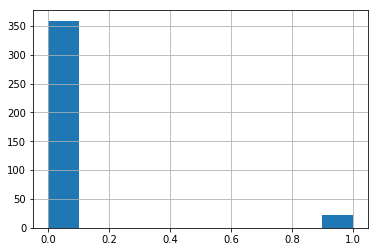

In [13]:
pd.Series(y_sub).hist()

In [14]:
pd.Series(y_sub).to_csv('test_prediction.csv', index=False, header=None)